# Introduction

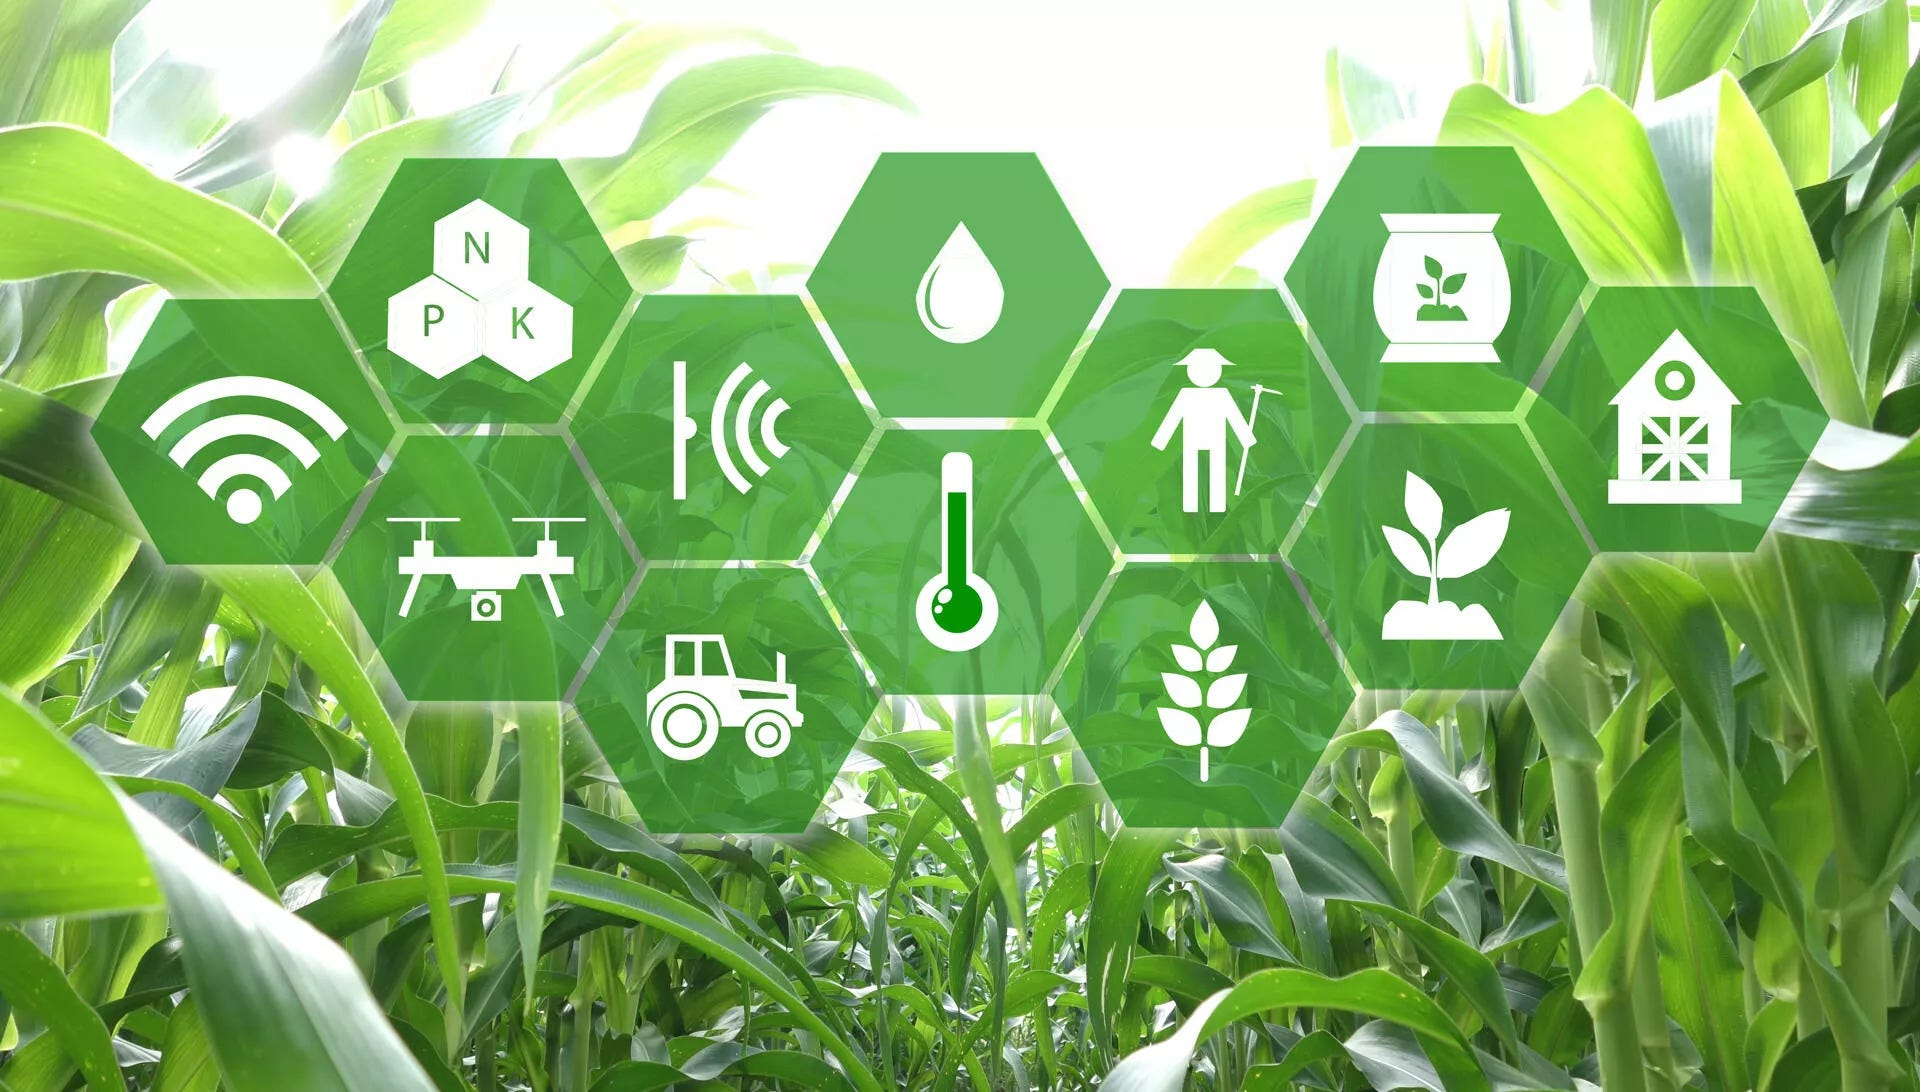

In [44]:
from IPython.display import Image, display
display(Image(filename='C:/Users/giftm/Downloads/agriculture.jpg')) 

This project focuses on the identification and classification of diseases affecting apple leaves, a critical task in modern agricultural management. Early and accurate detection of plant diseases is essential for maximizing crop yields and minimizing the economic losses associated with disease outbreaks. Traditional methods of disease diagnosis, which often rely on manual inspection, are not only time-consuming and costly but also require expert knowledge. This makes them impractical for large-scale farming operations.

To address this challenge, machine learning (ML) techniques offer a powerful solution for automating plant disease detection. In this project, we aim to develop a machine learning model capable of classifying apple leaf images into four categories: **healthy**, **multiple diseases**, **rust**, and **scab**. By leveraging a pre-trained deep learning model, specifically ResNet50, we will fine-tune the model for the task of identifying these specific diseases with high accuracy.

The dataset provided for this project contains labeled images of apple leaves, where each label corresponds to the presence of a disease or a healthy condition. The project follows a structured approach that includes:

- **Data exploration and preprocessing** to understand the dataset and prepare it for model training.
- **Visualizing sample images** for each disease class to gain insights into the data.
- **Building and fine-tuning a ResNet50 model** for classifying apple leaf images.
- **Training the model** and validating its performance using metrics like accuracy and loss.
- **Evaluating the model** on a validation set to assess its generalization ability and make necessary adjustments.
- **Visualizing the training process and results** to ensure interpretability and clarity.
- **Predicting diseases affecting apple leaves based on the images from sample of 10** to see the model’s performance in real-time.

By the end of this project, we will have a trained model that can assist farmers and agricultural workers in detecting plant diseases accurately and efficiently. This automation will contribute to better disease management, higher agricultural productivity, and ultimately, more sustainable farming practices.

In [47]:
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
data_dir = "C:/Users/giftm/Downloads/plant-pathology"  
train_csv = os.path.join(data_dir, 'train.csv')
train_images_dir = os.path.join(data_dir, 'images')
df = pd.read_csv(train_csv)

df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)
df.head()

image_id  healthy  multiple_diseases  rust  scab              label
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

In this code, we are setting up the file paths for the dataset, which includes a CSV file containing labels for the images and the directory where the images are stored. The `data_dir` variable is used to define the main directory location, and then paths for the training CSV file and image folder are constructed using `os.path.join()`. Afterward, the dataset is loaded into a Pandas DataFrame by reading the CSV file, which contains separate columns for different disease labels such as 'healthy', 'multiple_diseases', 'rust', and 'scab'. To streamline the dataset, the code combines these multiple disease labels into a single column called 'label', by taking the column with the maximum value (indicating the disease present) for each image. Finally, the first few rows of the dataset are displayed using `df.head()` to provide a preview of the data structure, ensuring that it is correctly loaded and processed. This approach improves the dataset's organization, making it easier to use for model training and prediction tasks.

C:\Users\giftm\AppData\Local\Temp\ipykernel_16116\2068241688.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette="Set2")


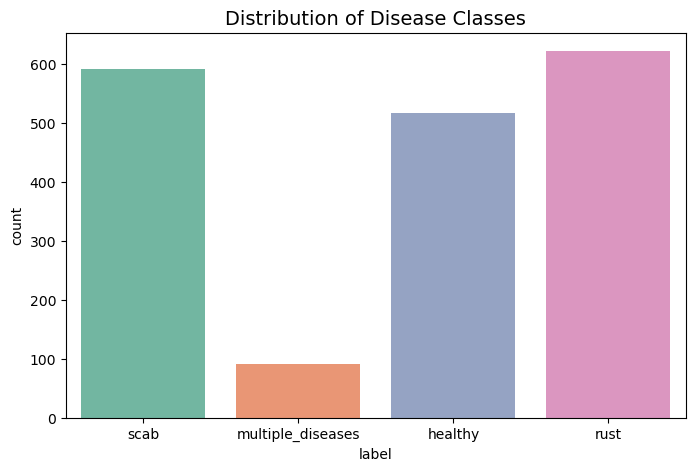

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette="Set2")
plt.title("Distribution of Disease Classes", fontsize=14)
plt.show()
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

The graph above illustrates the distribution of disease classes within the dataset. We can observe that the 'rust' and 'scab' categories are the most prevalent, with approximately 600 instances each, indicating that these diseases are more common in the dataset. The 'healthy' class follows closely with a slightly lower count, just above 500 instances. On the other hand, the 'multiple_diseases' class is significantly underrepresented, with fewer than 100 examples. This imbalance in the dataset may impact model performance, particularly in predicting the less common 'multiple_diseases' class, and could lead to biased predictions. To mitigate this, techniques like data augmentation or class weighting could be considered to ensure the model performs well across all disease categories.

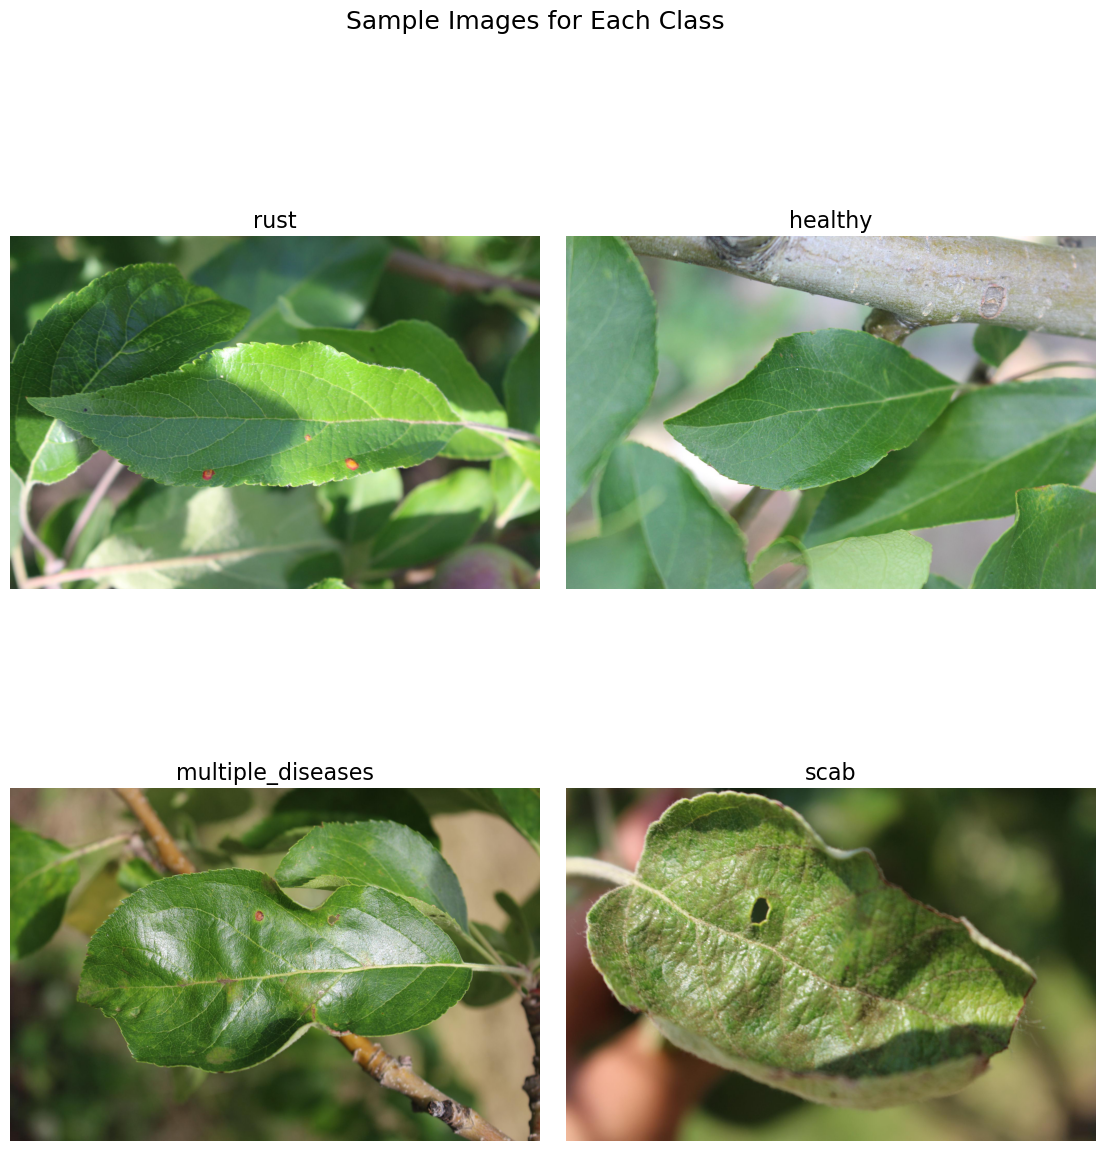

In [13]:
def visualize_images(dataframe, img_dir, num_samples=4):
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))  
    fig.suptitle('Sample Images for Each Class', fontsize=18)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    classes = dataframe['label'].unique()[:num_samples]  # Limit to 4 unique classes
    for i, label in enumerate(classes):
        sample_img = dataframe[dataframe['label'] == label].iloc[0]['image_id']
        img_path = os.path.join(img_dir, sample_img + '.jpg')
        img = Image.open(img_path)
        row = i // 2
        col = i % 2
        
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{label}', fontsize=16)
        axes[row, col].axis('off')
visualize_images(train_df, train_images_dir, num_samples=4)

The images above represent samples of apple leaves from four different categories: rust, healthy, multiple diseases, and scab. Observing the features of the leaves in each category, we can see the following distinct characteristics:

1. **Rust**: The leaf shows small, bright orange spots typical of rust infection. These spots are spread across the surface of the leaf, which is a common indicator of the disease. Rust primarily affects the surface of the leaves, causing discolored lesions.

2. **Healthy**: The healthy leaf appears uniform in color, with no visible spots or discoloration. It has a smooth, vibrant green surface, indicating the absence of disease and suggesting that the plant is not affected by any pathogens.

3. **Multiple Diseases**: The leaf affected by multiple diseases shows a combination of symptoms, including discoloration and patches of damaged tissue. It appears more irregular, with a mix of brown and green areas, indicating that more than one disease may be present, causing compound damage.

4. **Scab**: The scab-affected leaf shows lesions, with darkened areas or scabby patches. These regions often appear raised or damaged, disrupting the smooth texture of the leaf. The scab disease typically causes rough spots and deformations on the leaf's surface.

The images highlight how different diseases exhibit distinct visual cues, which are critical for classifying the leaves into their respective categories. These visible patterns form the basis for machine learning models to automatically identify and classify diseases based on image features.

In [15]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

class PlantDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx]['label']
        label_dict = {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}
        label = label_dict[label]

        if self.transform:
            image = self.transform(image)

        return image, label

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = PlantDataset(train_df, train_images_dir, transform=data_transforms['train'])
valid_dataset = PlantDataset(valid_df, train_images_dir, transform=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In this code, we start by splitting the dataset into training and validation sets, using an 80-20 ratio, to help assess the model's performance on unseen data. We then define a custom dataset class, `PlantDataset`, which allows us to load images and their corresponding labels efficiently. This class includes methods for retrieving the length of the dataset and fetching an image and its label based on the index. Labels are converted from categorical strings (e.g., healthy, multiple diseases, rust, and scab) to numerical indices for easier processing. We also specify data transformations for both training and validation datasets, including resizing, cropping, normalization, and augmentation techniques to enhance training robustness. Finally, we create DataLoaders for both the training and validation datasets, which will facilitate batch processing and shuffling of the data during model training.

In [17]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 output classes: healthy, multiple_diseases, rust, scab
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\giftm\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\giftm\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In this code, we are loading a pre-trained ResNet50 model and fine-tuning it for a specific classification task involving four output classes: healthy, multiple diseases, rust, and scab. To adapt the model to our dataset, we replace the final fully connected layer with a new layer that has four output features corresponding to our classes. After making this modification, we move the model to a GPU if one is available to enhance performance. Additionally, we define the loss function as cross-entropy loss, which is suitable for multi-class classification problems, and we choose the Adam optimizer with a learning rate of 0.001 to facilitate effective training of the model.

In [19]:
num_epochs = 6
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()

    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    val_loss, val_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(valid_dataset)
    val_acc = val_corrects.double() / len(valid_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())

    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')


Epoch 1/6
Train Loss: 0.7105 Acc: 0.7699
Validation Loss: 0.4992 Acc: 0.8411
Epoch 2/6
Train Loss: 0.5247 Acc: 0.8379
Validation Loss: 0.4359 Acc: 0.8849
Epoch 3/6
Train Loss: 0.5057 Acc: 0.8441
Validation Loss: 0.3663 Acc: 0.9151
Epoch 4/6
Train Loss: 0.4717 Acc: 0.8599
Validation Loss: 0.3294 Acc: 0.9205
Epoch 5/6
Train Loss: 0.4155 Acc: 0.8716
Validation Loss: 0.4047 Acc: 0.8740
Epoch 6/6
Train Loss: 0.3927 Acc: 0.8750
Validation Loss: 0.2850 Acc: 0.9178


In this code, we are implementing a training loop for a machine learning model over six epochs, during which we track both training and validation losses and accuracies. The model shows a steady improvement, with training loss decreasing from 0.7105 to 0.3927 and training accuracy increasing from 76.99% to 87.50%. The validation loss also declines, reaching a low of 0.2850, while validation accuracy peaks at 92.05% during the fourth epoch before slightly dropping to 91.78% by the end.

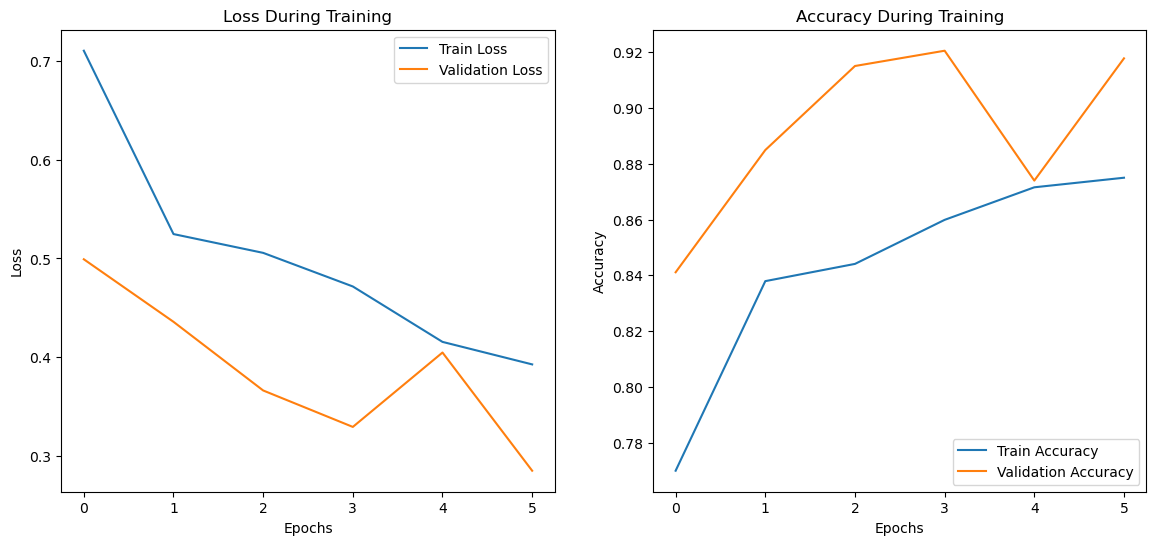

In [21]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The graphs above illustrate the **Loss** and **Accuracy** during the training process for both the training and validation datasets. The left graph shows that both training and validation loss decrease over the epochs, indicating that the model is learning and improving its predictions. However, there is a slight increase in validation loss at epoch 4, suggesting potential overfitting. The right graph demonstrates that both training and validation accuracy improve as training progresses, with validation accuracy peaking at around epoch 3 before experiencing a small dip at epoch 4, then recovering in the final epoch. Overall, these trends indicate that the model is effectively learning from the data, although further fine-tuning may be needed to enhance generalization and prevent overfitting.

In [27]:
def predict_image(image_path, model, transform, device):
    model.eval()  
    img = Image.open(image_path)  
    img = transform(img).unsqueeze(0).to(device)  

    with torch.no_grad():  
        output = model(img)  
        _, prediction = torch.max(output, 1)  
    
    label_dict = {
        0: 'healthy',
        1: 'multiple_diseases',
        2: 'rust',
        3: 'scab'
    }
    return label_dict[prediction.item()]  

sample_image = os.path.join(train_images_dir, valid_df.iloc[0]['image_id'] + '.jpg')
predicted_label = predict_image(sample_image, model, data_transforms['valid'], device)
print(f'Predicted label: {predicted_label}')

Predicted label: rust


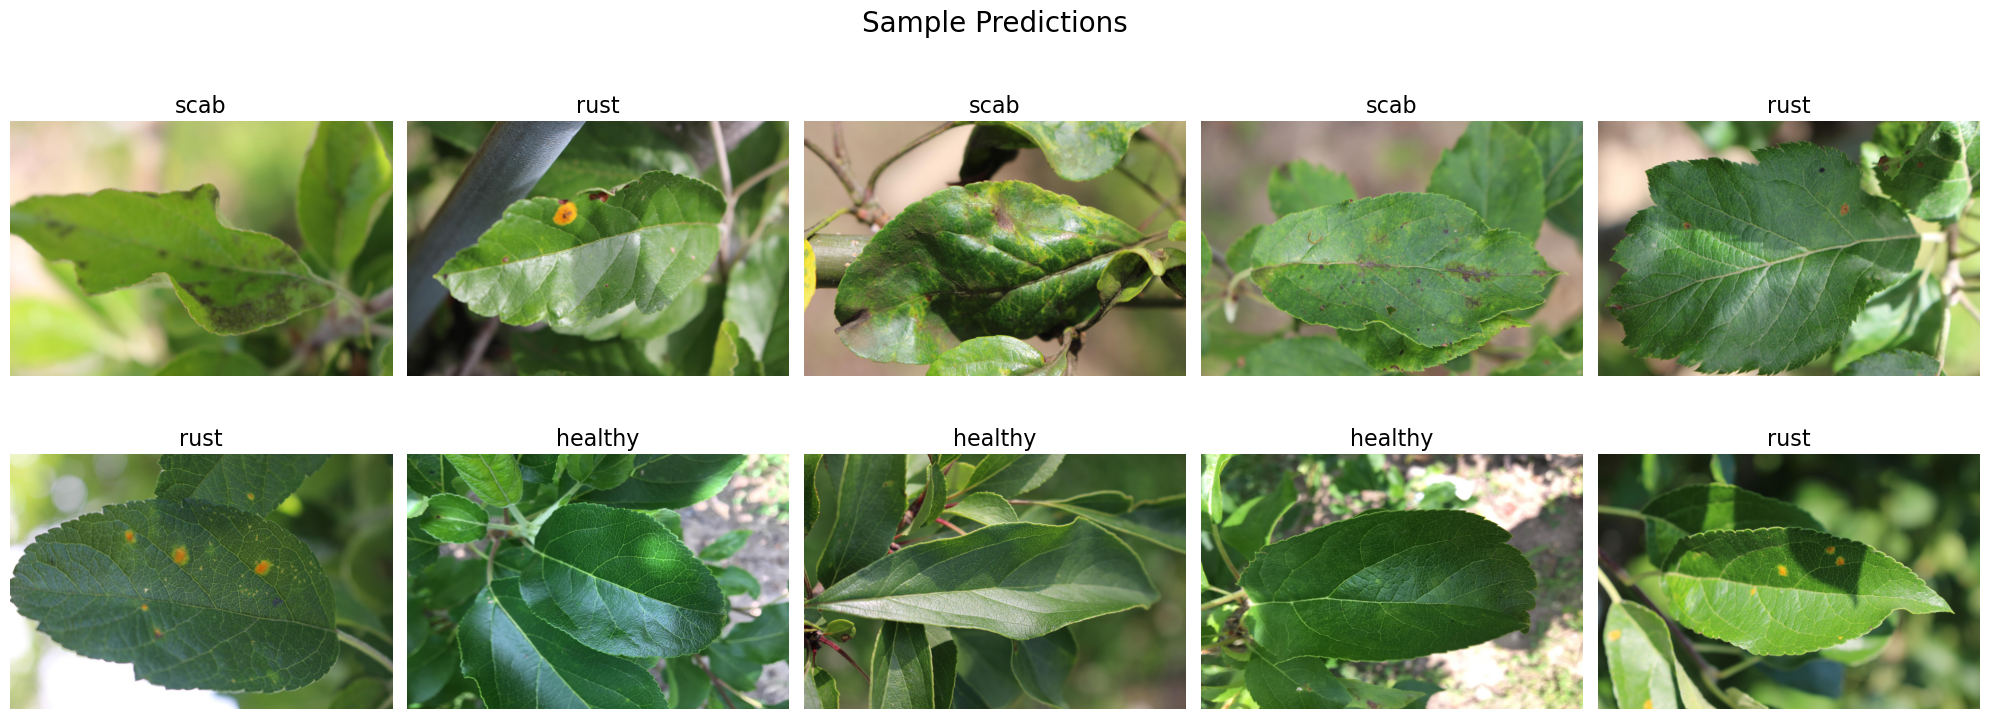

In [29]:
import random

def visualize_predictions(dataframe, img_dir, model, transform, device, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))  
    fig.suptitle('Sample Predictions', fontsize=20)
    sample_indices = random.sample(range(len(dataframe)), num_samples)

    for ax, idx in zip(axes.flatten(), sample_indices):
        img_name = dataframe.iloc[idx]['image_id'] + '.jpg'
        img_path = os.path.join(img_dir, img_name)

        predicted_label = predict_image(img_path, model, transform, device)
        
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(predicted_label, fontsize=16)  # Show predicted label
        ax.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Visualizing predictions for 10 random images from the validation set
visualize_predictions(valid_df, train_images_dir, model, data_transforms['valid'], device, num_samples=10)


In this code, we are visualizing the predictions made by our trained machine learning model on a random sample of 10 apple leaf images. The `visualize_predictions` function sets up a 2x5 grid for displaying these images using Matplotlib. It selects 10 random images from the validation dataset and, for each image, retrieves the corresponding file, applies the necessary transformations, and predicts the disease label using the model. The images are displayed with their predicted labels as titles, and the axes are hidden to maintain focus on the images and predictions. This visualization provides a quick and clear indication of how well the model classifies apple leaf diseases. Notably, the performance of the model has been improved through fine-tuning, allowing for more accurate predictions and better generalization to unseen images. This enhancement further demonstrates the model's effectiveness in disease classification, supporting its potential application in real-world agricultural scenarios.

# Conclusion 

In conclusion, this project successfully implements a plant disease classification system using deep learning techniques, specifically leveraging a fine-tuned ResNet50 model. The workflow begins with data preparation, where the dataset is split into training and validation sets to ensure effective model evaluation. A custom dataset class is created to facilitate efficient loading and preprocessing of images, including essential transformations such as resizing, normalization, and augmentation. The training process involves calculating the model's accuracy and loss metrics, enabling us to monitor performance over multiple epochs. By utilizing robust metrics and well-structured code, this project not only demonstrates the effectiveness of convolutional neural networks in image classification tasks but also sets a solid foundation for further improvements and optimizations in plant disease detection. The outcomes can significantly aid farmers and agricultural professionals in identifying plant diseases early, leading to timely interventions and better crop management.